#### validation dataset generation   

In [ ]:
import torch
import numpy as np
from glob import glob
import rasterio as rio
from pyrsimg import img2patch
from notebooks import config
import matplotlib.pyplot as plt
from torchvision.transforms import v2 
from pyrsimg import imsShow, imgShow


In [2]:
## we set base patch size to 512, the 256x256 is cropped from 512x512 patch
patch_size = 512  ## base patch size


In [3]:
# ## valset
paths_valset = list(zip(config.paths_scene_val, 
                        config.paths_dem_val, 
                        config.paths_truth_val))
paths_valset[4]


('data/dset/scene/scene_nor/l7_scene_08.tif',
 'data/dset/dem/dem_nor/l7_scene_08_dem.tif',
 'data/dset/truth/truth_tif/l7_scene_08.tif')

In [24]:
## generate validation patches (include patch,dem,truth)
dset_patch_list = []
dset_start_list = []
dset_list = []       
for path_scene, path_dem, path_truth in paths_valset:
    scene_val_arr = rio.open(path_scene).read()   ## (C, H, W)
    truth_val_arr = rio.open(path_truth).read(1)
    dem_val_arr = rio.open(path_dem).read()  
    size_global = scene_val_arr.shape[1:]
    ## image to patches
    scene_dem_truth_arr = np.concatenate([scene_val_arr, 
                                        dem_val_arr,   # dem/dem_adjust
                                        truth_val_arr[np.newaxis, ...]], 
                                        axis=0)
    img2patches = img2patch(img = scene_dem_truth_arr.transpose(1,2,0), 
                            patch_size = patch_size, 
                            edge_overlay = 40,   ## 0,40,100 for patch_256, patch_512, patch_1024
                            drop_last=True)
    patch_dem_truth_list = img2patches.toPatch()
    print(len(patch_dem_truth_list))
    dset_list.extend(patch_dem_truth_list)
    break
print('num of patches:', len(dset_list))


9
num of patches: 9


In [25]:
'''----  save multiscale patch data  ----'''
dir_valset = f'data/dset/valset/patch_{patch_size}'
for id_patch, patch_pdem_ptruth in enumerate(dset_list):
    print(id_patch)
    patch_pdem_ptruth_ = torch.from_numpy(patch_pdem_ptruth).permute(2,0,1)  ## (C, H, W)  
    ## save as float16 to save space
    patch_pdem_ptruth_ = patch_pdem_ptruth_.to(dtype=torch.float16)
    # patch_lat = dset_list[id_patch]
    path_save = dir_valset+f'/patch_pdem_ptruth_' + str(id_patch).rjust(4,'0')+'.pt'
    print(path_save)
    torch.save((patch_pdem_ptruth_), path_save)
    break


0
data/dset/valset/patch_512/patch_pdem_ptruth_0000.pt


### load data and check

In [ ]:
## load data
# paths_valset_256 = sorted(glob('data/dset/valset/patch_256/*'))
# valset_256_list = [torch.load(path, weights_only=False) for path in paths_valset_256]
paths_valset_512 = sorted(glob('data/dset/valset/patch_512/*'))
valset_512_list = [torch.load(path, weights_only=False) for path in paths_valset_512]
# paths_valset_1024 = sorted(glob('data/dset/valset/patch_1024/*'))
# valset_1024_list = [torch.load(path, weights_only=False) for path in paths_valset_1024]
print(len(valset_512_list)) 



117


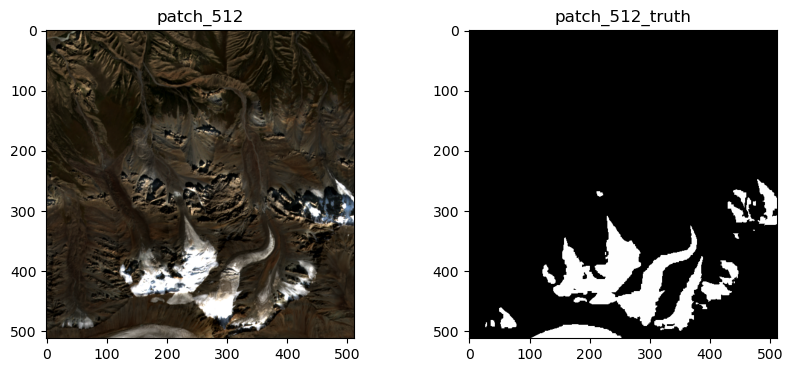

In [ ]:
id = np.random.randint(0, len(valset_512_list))
# patch_256 = valset_256_list[id][0].numpy().astype(np.float32).transpose(1,2,0)
patch_512 = valset_512_list[id].numpy().astype(np.float32).transpose(1,2,0)
# patch_1024 = valset_1024_list[id][0].numpy().astype(np.float32).transpose(1,2,0)
imgs_name = ['patch_512', 'patch_512_truth']  
col_bands_list = [(2,1,0), (7,7,7)]
imsShow(img_list=[patch_512, patch_512], 
            img_name_list=imgs_name,
            clip_list=[2,0], 
            color_bands_list=col_bands_list,
            figsize=(10,4)
            );
